In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pathlib
import logging
import sys
from sklearn.linear_model import LinearRegression

logging.basicConfig(stream=sys.stdout, level=logging.INFO)

from convenience import quick_eval
from comparison_fns import eval_alt_split

data_dir = pathlib.Path('/qfs/projects/thidwick/manga')
results_dir = pathlib.Path('/qfs/projects/thidwick/weights/manga')

### Datacube evaluation

In [1]:
from eval_utils import(
    datacube_evaluator
)
import torch
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from utils import plateid_to_fits_file
from comparison_fns import visualize_gal_labels
results_dir = pathlib.Path('/qfs/projects/thidwick/weights/manga')

collecting predictions: 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]


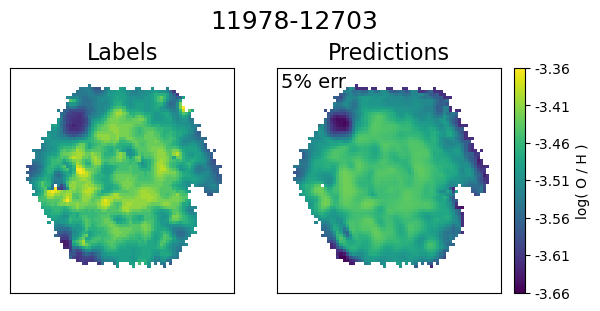

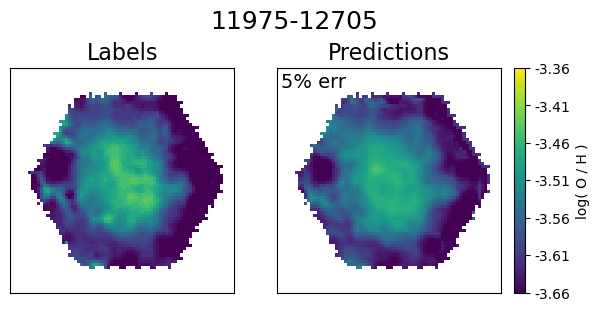

In [2]:
device = torch.device('cuda:0')

metric='MAPE'
arch_type = 'simplenet'
reg_norm = 'scaledmax'
model_name = f'OH_2_base_reg_{reg_norm}'

list_of_ids = ['11978-12703', '11975-12705']
model_weights_dir = results_dir / arch_type / model_name

for plate_id in list_of_ids:
    fits_file = plateid_to_fits_file(plate_id)
    # output is a dictionary with predictions and ground truth labels
    output = datacube_evaluator(
        fits_file,
        arch_type=arch_type, 
        model_weights_dir=results_dir / arch_type / model_name,
        device=device,
        num_workers=4,
        task='regression',
        regression_norm=reg_norm,
    )
    visualize_gal_labels(
        plate_id, output, title=f'{plate_id}',
        OH_log=False,
        task='regression',
        regression_norm=reg_norm,
        cb_label='log( O / H )',
        regression_scale='logOH',
        metric=metric,
        save_fig=True,
        output_path=f'./figs/reg/{model_name}_{arch_type}_{metric}_{plate_id}.png',
    )


### Test split evaluation

In [2]:
device = torch.device('cuda:0')

arch_type = 'simplenet'
split_dir='OH_2'
reg_norm = 'scaledmax'

model_suff = 'base_reg_scaledmax'

out = quick_eval(
    arch_type=arch_type,
    model_suff=model_suff,
    split_dir=split_dir,
    device=device,
    task='regression',
    regression_norm=reg_norm,
    base_results_dir=results_dir
)

---- simplenet / OH_2_base_reg_scaledmax ----------
INFO:root:Using regression normalization: scaledmax
INFO:root:Loading SimpleNet


collecting predictions: 100%|██████████| 38/38 [00:29<00:00,  1.29it/s]


Raw O/H
	MAE: 2.4e-05
	MAPE:  8.0%
12+logO/H
	MAE: 3.5e-02
	MAPE:  0.4%
O/H ppm
	MAE:      24
	MAPE:  8.0%


	 Residual slope: -0.3 / Residual offset: -1.2


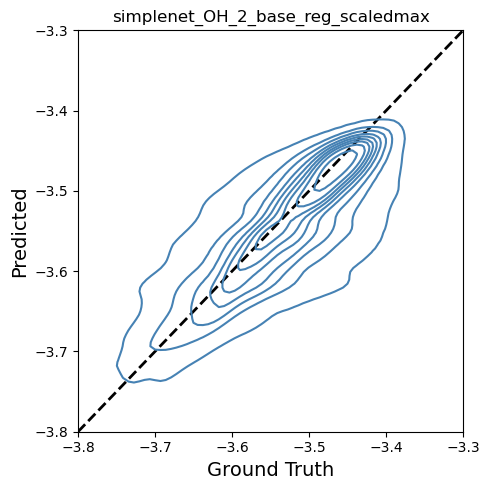

In [6]:
lims = [-3.8,-3.3]
pred = out['predictions'] - 12.0
labs = out['labels'] - 12.0

# residual fitting ----------------
resid = pred-labs
reg = LinearRegression().fit(labs.reshape(-1,1), resid)
slp = np.round(reg.coef_.item(),2)
y_int = np.round(reg.intercept_,1)
xr = np.linspace(lims[0], lims[1])

print(f'\t Residual slope: {slp:.1f} / Residual offset: {y_int:.1f}')

# KDE plot ----------------
fig,ax = plt.subplots(figsize=(5,5))
ax.plot(lims,lims, 'k--', lw=2)

sns.kdeplot(
    x=labs,
    y=pred,
    gridsize=100,
    ax=ax,
    color='SteelBlue',
    label='DL'
)

ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel(f'Ground Truth', size=14)
ax.set_ylabel(f'Predicted', size=14)

ax.set_title(f'{arch_type}_{split_dir}_{model_suff}', size=12)
plt.tight_layout()
fig.savefig(f'./figs/KDE.png')